In [139]:
import numpy as np
from math import floor
import tau.data_utils as du
import tau.train_utils as tu
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from PIL import Image
import matplotlib.pyplot as plt
import csv
import os
import shutil
import re
from tqdm import tqdm_notebook as tqdm
import gc

%load_ext autoreload
%autoreload 2
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Config
train_dir = 'data/train/'
valid_dir = 'data/valid/'
test_dir = 'data/test/'
has_header = True
train_file = 'train_labels.csv'
valid_file = 'valid_labels.csv'

In [26]:
# Mean/std stats from Jeremy Howard's CIFAR-10 notebook.
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = len(classes)
stats = {'mean' : np.array([ 0.4914 ,  0.48216,  0.44653]), 'std' : np.array([ 0.24703,  0.24349,  0.26159])}
data_path = {'train' : train_dir,
            'val' : valid_dir,
            'test' : test_dir}
csvfile = {'train' : train_file,
          'val' : valid_file,
          'test' : None}
shuffle = {'train' :  True,
          'val' : False,
          'test' : False}
max_read = {'train' : 256,
           'val' : 32,
           'test' : 0}
img_size = 32
batch_size = 32
num_workers = 0

In [27]:
# Read data
data_transforms = {'train' : transforms.Compose([
                        transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
                        transforms.RandomHorizontalFlip(),
                        transforms.ToTensor(),
                        transforms.Normalize(stats['mean'], stats['std'])]),
                  'val' : transforms.Compose([transforms.ToTensor(),
                                               transforms.Normalize(stats['mean'], stats['std'])]),
                  'test' : transforms.Compose([transforms.ToTensor(),
                                              transforms.Normalize(stats['mean'], stats['std'])])}
image_datasets = {x : du.SingleLabelImages(x, data_path[x], csvfile[x], classes, '.png', 
                                    data_transforms[x], max_read[x]) for x in ['train', 'val', 'test']}
image_loaders = {x : DataLoader(image_datasets[x], shuffle=shuffle[x], batch_size=batch_size, 
                                num_workers=num_workers) for x in ['train', 'val', 'test']}

Read 256 train images.
Read 32 val images.
Read 0 test images.


In [5]:
# sample = image_datasets['train'].__getitem__(30)
print(image_loaders['train'].dataset.__len__())
image_loaders['train'].batch_size

128


8

In [ ]:
# Returns an image in numpy array form with shape (H, W, C)
def DenormalizeImage(img_tensor, mean, std):
    return np.clip(img_tensor.numpy().transpose((1,2,0))*std + mean, 0.0, 1.0)
plt.rcParams['figure.dpi'] = 30
_ = plt.imshow(DenormalizeImage(sample['image'], stats['mean'], stats['std']))
plt.show()
print('Label: {}'.format(classes[sample['label']]))

HBox(children=(IntProgress(value=0, max=200), HTML(value='')))

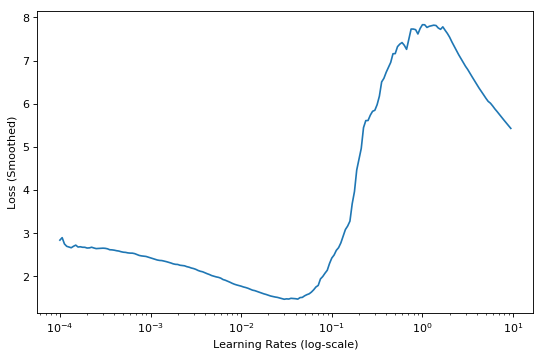

In [28]:
model_setup = tu.NeuralNet(device, 'resnet18', 'cross_entropy', 10, image_loaders, pre_trained=True)
lr_finder = model_setup.exploreLR()
lr_finder.plot_findings()

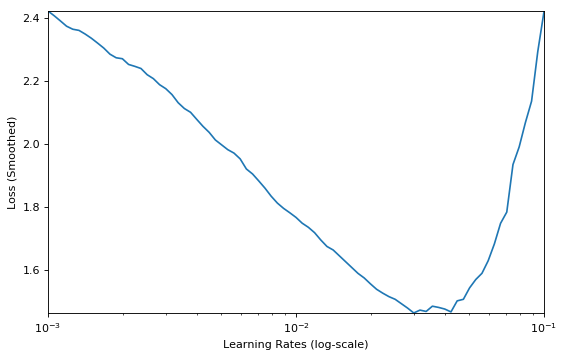

In [29]:
lr_finder.zoomPlot(min_lr=1e-3, max_lr=1e-1)

In [130]:
model = tu.NeuralNet(device, 'resnet18', 'cross_entropy', 10, image_loaders, pre_trained=True)
model.setOptim('sgd', lr=10**(-3), weight_decay=0.01)
model.setScheduler(sched_name='cyclical', min_lr=10**(-2.5), max_lr=10**(-1.6))
model.setStatList(['train_acc', 'val_acc', 'val_loss'])

In [131]:
trainer = tu.Trainer(device, model, '')
trainer.train(image_loaders, num_iters=50, iter_type='batch')

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

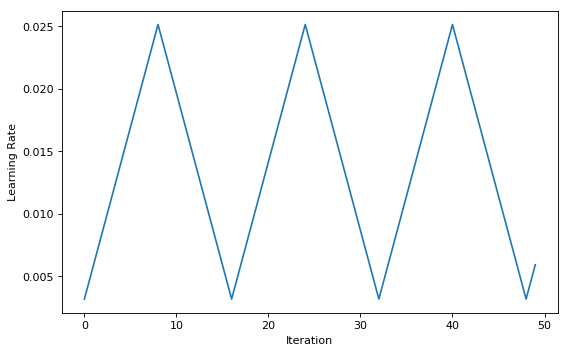

In [132]:
trainer.plotLR()

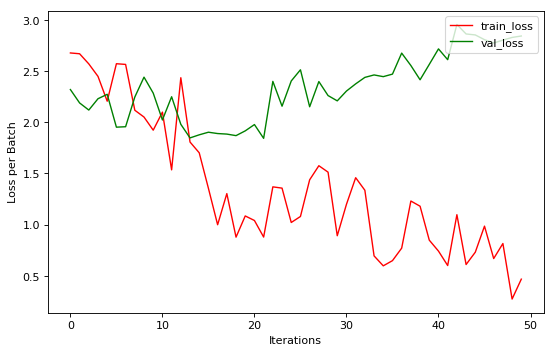

In [133]:
trainer.plotLoss()

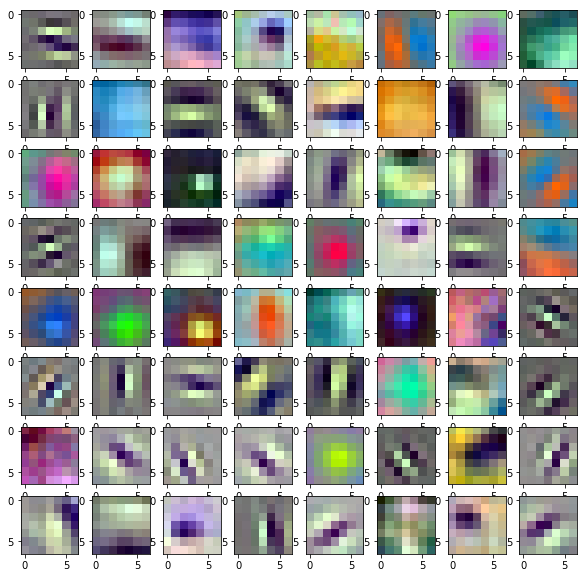

In [140]:
model.printFirstLayerFilters()